In [1]:
import os
import random
import datetime

import numpy as np
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from model import transform, predict, CNNModel, ViTModel
from mydataset import split_dataset

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
BATCH_SIZE = 24
TR_RATIO = 0.8
train_dataset, dev_dataset, train_loader, dev_loader = split_dataset(16, TR_RATIO)
train_size = len(train_dataset)

dataset size 577
tr size 461 dev size 116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


样本[342]: torch.Size([3, 224, 224]), 标签: 1


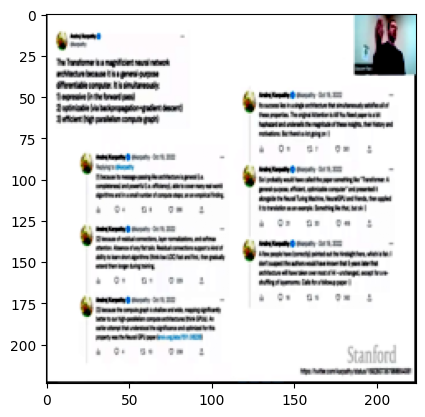

In [3]:
idx = np.random.randint(0, train_size)
img, lbl = train_dataset[idx]
print(f"样本[{idx}]: {img.shape}, 标签: {lbl}")  # 输出: 样本: torch.Size([3, 224, 224]), 标签: 1 (正例)

plt.imshow(img.permute(1, 2, 0));

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel().to(DEVICE)

params_total = sum(p.numel() for p in model.parameters())
print('parameters', f'{params_total:,}', f"{params_total / 1e9:.2f}B")

parameters 51,475,010 0.05B


In [8]:
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

running_loss, running_dev_loss = [], []
running_acc, running_dev_acc = [], []

def train(epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0  # 记录训练分类准确率
        tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    
        for images, labels in tqdm_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
    
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
            # 计算分类准确率
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            running_loss.append(loss.item())
            running_acc.append(correct / total)
    
            tqdm_bar.set_postfix(loss=loss.item(), acc=f"{correct/total:.4f}")
    
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {correct/total:.4f}")
        if correct/total > .95:
            model_filename = f"slide_classifier_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{epoch+1:03d}.pth"
            torch.save(model.state_dict(), model_filename)
            print("✅ 保存模型", model_filename)

        fig = plt.figure()
        plt.plot(running_loss, label='tr loss')
        plt.legend()
        fig = plt.figure()
        plt.plot(running_acc, label='tr acc')
        plt.legend()
        plt.show()

        # ✅ 验证阶段
        model.eval()
        dev_loss, dev_correct, dev_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in dev_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
    
                outputs = model(images)
                loss = criterion(outputs, labels)
                dev_loss += loss.item()
    
                preds = torch.argmax(outputs, dim=1)
                dev_correct += (preds == labels).sum().item()
                dev_total += labels.size(0)
    
        dev_acc = dev_correct / dev_total
        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {dev_loss/dev_total:.4f}, Validation Accuracy: {dev_acc:.4f}")

Epoch 1/5: 100%|█████████████████████████| 29/29 [00:15<00:00,  1.83it/s, acc=0.7787, loss=0.294]


Epoch [1/5], Train Loss: 0.6812, Train Acc: 0.7787


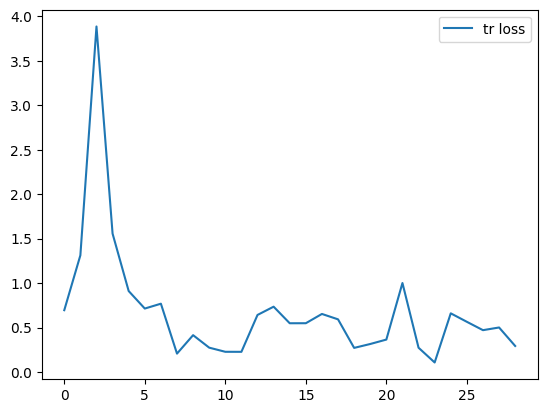

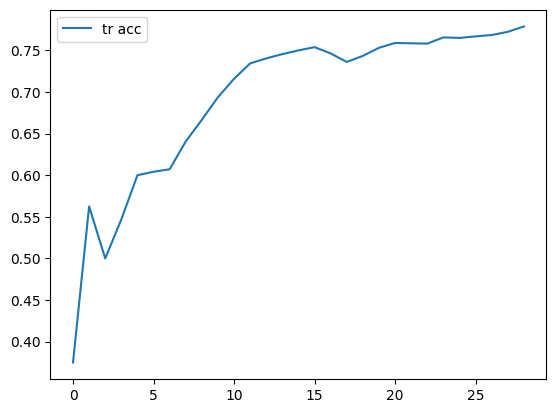

Epoch [1/5], Validation Loss: 0.0306, Validation Accuracy: 0.8190


Epoch 2/5: 100%|█████████████████████████| 29/29 [00:17<00:00,  1.69it/s, acc=0.9024, loss=0.234]

Epoch [2/5], Train Loss: 0.2757, Train Acc: 0.9024


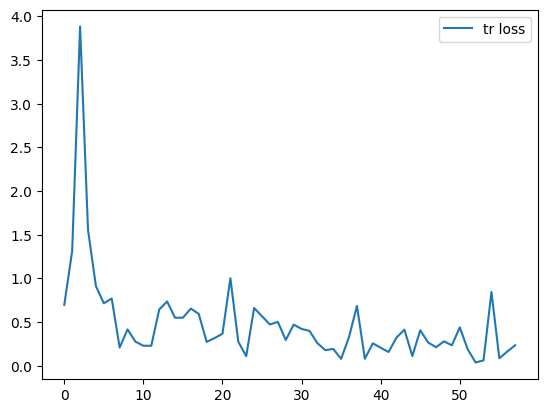

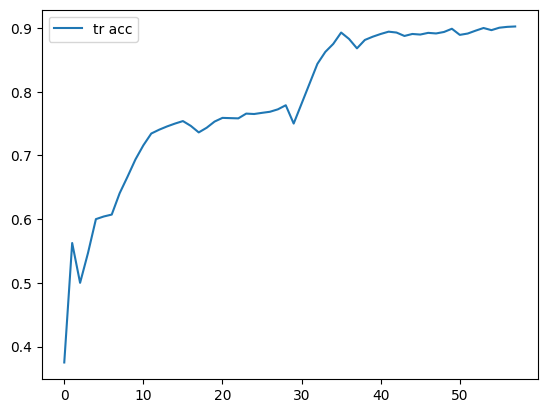

Epoch [2/5], Validation Loss: 0.0191, Validation Accuracy: 0.8966


Epoch 3/5: 100%|█████████████████████████| 29/29 [00:15<00:00,  1.88it/s, acc=0.9219, loss=0.176]

Epoch [3/5], Train Loss: 0.2018, Train Acc: 0.9219


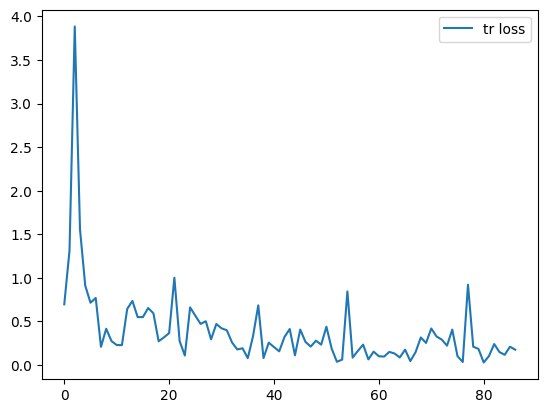

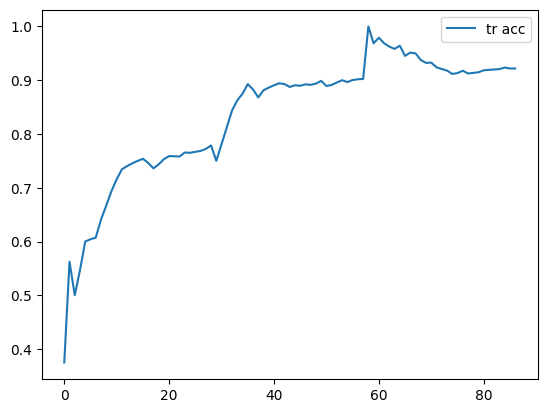

Epoch [3/5], Validation Loss: 0.0196, Validation Accuracy: 0.8879


Epoch 4/5: 100%|████████████████████████| 29/29 [00:15<00:00,  1.87it/s, acc=0.9544, loss=0.0829]


Epoch [4/5], Train Loss: 0.1210, Train Acc: 0.9544
✅ 保存模型 slide_classifier_20250225_074659_004.pth


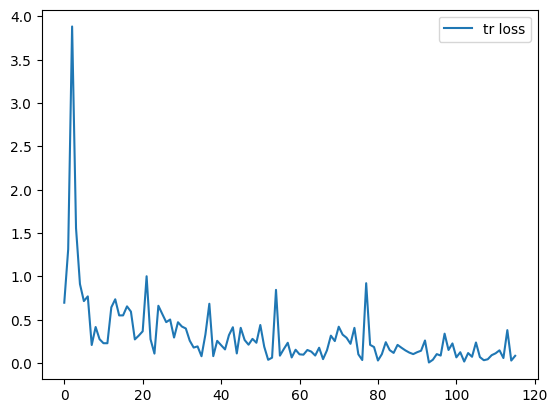

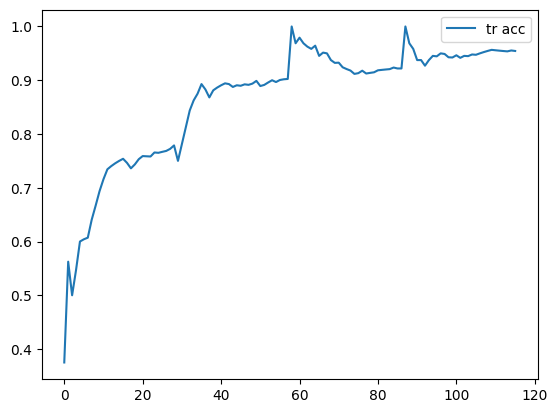

Epoch [4/5], Validation Loss: 0.0155, Validation Accuracy: 0.9397


Epoch 5/5: 100%|████████████████████████| 29/29 [00:15<00:00,  1.86it/s, acc=0.9631, loss=0.0225]


Epoch [5/5], Train Loss: 0.0818, Train Acc: 0.9631
✅ 保存模型 slide_classifier_20250225_074717_005.pth


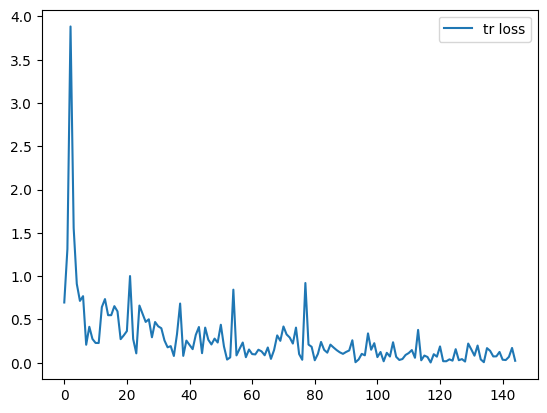

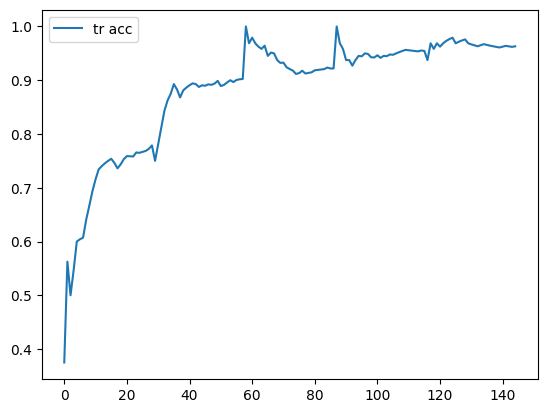

Epoch [5/5], Validation Loss: 0.0243, Validation Accuracy: 0.8707


In [9]:
train(5)

In [53]:

def load_labeled_images():
    """ 读取正例和负例文件，返回两个列表 """
    positive_images, negative_images = set(), set()
    
    if os.path.exists(POSITIVE_LABEL_FILE):
        with open(POSITIVE_LABEL_FILE, "r") as f:
            positive_images = set(line.strip() for line in f)
    
    if os.path.exists(NEGATIVE_LABEL_FILE):
        with open(NEGATIVE_LABEL_FILE, "r") as f:
            negative_images = set(line.strip() for line in f)

    return list(positive_images), list(negative_images)


def get_all_images(base_dir):
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")
    images = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(image_extensions):
                rel_path = os.path.relpath(os.path.join(root, file), base_dir)
                images.append(rel_path)
    return sorted(images)

all_images = get_all_images(IMAGE_BASE_PATH)
positive_images, negative_images = load_labeled_images()
labeled_images = set(positive_images + negative_images)
filtered_images = [img for img in all_images if img not in labeled_images]
len(all_images), len(labeled_images), len(filtered_images)

(403, 385, 18)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1 预测结果: 正例
1 预测结果: 正例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47450978..0.94509804].


1 预测结果: 正例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4980392..0.92941177].


0 预测结果: 负例
0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.52156866].


0 预测结果: 负例
0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46666664..0.9607843].


1 预测结果: 正例
1 预测结果: 正例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4980392..0.9843137].


1 预测结果: 正例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29411763..0.9529412].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


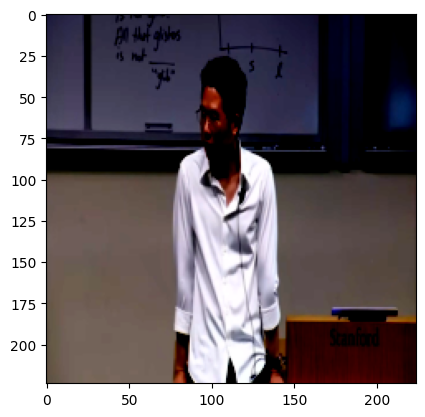

In [61]:
# ✅ 预测新图片
samples = random.sample(filtered_images, BATCH_SIZE)
for img_path in samples:
    img_path = os.path.join(IMAGE_BASE_PATH, img_path)
    img, label = predict(img_path, model, transform, DEVICE)
    img = img.squeeze(0)
    plt.imshow(img.permute(1, 2, 0))
    print(label, f"预测结果: {'正例' if label == 1 else '负例'}")
    
#image_path = "test_image.jpg"
#label = predict_image(image_path, model, transform, device)
#print(f"预测结果: {'正例' if label == 1 else '负例'}")